In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
import random
import time
from monai.networks.nets import BasicUNet
from monai.losses.dice import GeneralizedDiceLoss


model_path = "/Users/weinan/Downloads/P22-Multiview-segmentation-main/trained_unet_model.pth"

In [2]:
# Load the saved model
model = BasicUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=2,
    features=(32, 64, 128, 256, 512, 32),
    dropout=0.2
)
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))
GDL = GeneralizedDiceLoss(include_background=False,to_onehot_y=True,softmax=False)

BasicUNet features: (32, 64, 128, 256, 512, 32).


In [5]:
# Paths to the image and mask
image_path = "/Users/weinan/Downloads/P22-Multiview-segmentation-main/Data/valandtest/Alexa488_Fibroblasts_well1_50locations_s01z06c2_ORG.tif"
mask_path = "/Users/weinan/Downloads/P22-Multiview-segmentation-main/Data/valandtest/Alexa488_Fibroblasts_well1_50locations_s01z06c1_ORG_mask.tiff"

# Load the image and mask
image = np.array(Image.open(image_path).convert('L')) / 255.0  # Normalize to [0, 1]
mask = np.array(Image.open(mask_path).convert('L')) / 255.0   # Normalize to [0, 1]

# Convert to PyTorch tensors and add a batch dimension
image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)
mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0)    # Shape: (1, 1, H, W)

# Move tensors to the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_tensor = image_tensor.to(device)
mask_tensor = mask_tensor.to(device)


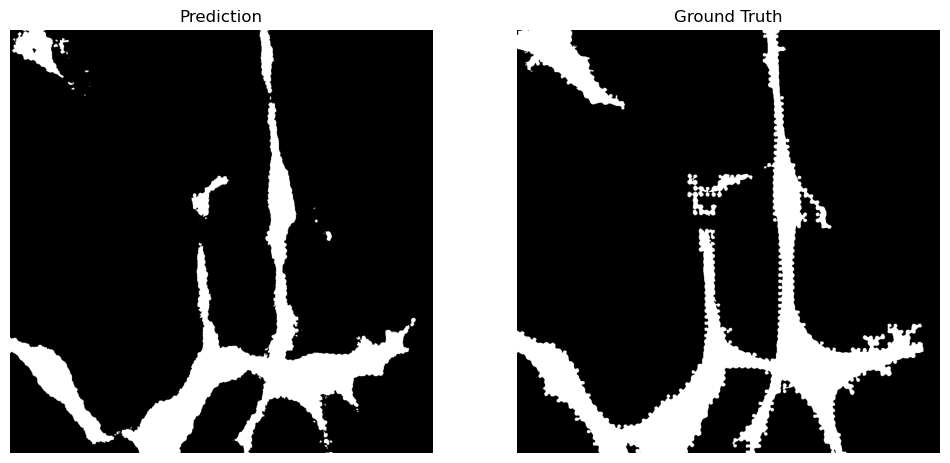

In [6]:
with torch.no_grad():
    # Forward pass through the model
    segmentation_output = model(image_tensor)  # Output shape: (1, num_classes, H, W)
    segmentation_output = segmentation_output.softmax(dim=1)  # Apply softmax to get probabilities

    # Get the predicted class for each pixel
    preds = torch.argmax(segmentation_output, dim=1).squeeze(0)  # Remove batch dimension

# Move predictions back to CPU for visualization
preds = preds.cpu().numpy()
mask = mask_tensor.cpu().numpy().squeeze()  # Remove batch and channel dimensions

# Visualize the prediction and ground truth
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(preds, cmap='gray')
axes[0].set_title('Prediction')
axes[0].axis('off')

axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Ground Truth')
axes[1].axis('off')

plt.show()